### 0. Paths & libraries

In [1]:
import os
import sys

# Paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
utils_path = os.path.join(project_root, 'utils')
models_path = os.path.join(project_root, 'models')
data_path = os.path.join(project_root, 'data_sample')

# Add utils path to sys.path
sys.path.append(utils_path)

In [2]:
import time
import math
import random
from tqdm.notebook import tqdm  # Notebook-friendly version
import warnings
import joblib
warnings.filterwarnings("ignore")

# Data manipulation
import numpy as np
import rasterio as rio
import numpy as np
import pandas as pd
import data_preprocessing as dP

# Statistics
from scipy.stats import randint, uniform
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

# from osgeo import gdal
# from scipy import ndimage, datasets
from scipy.ndimage import binary_dilation,binary_opening
# from PIL import Image, ImageFilter

# Plotting
# import richdem as rd
# from glob import glob
# from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns
import viz as vz
import plotly.express as px
import plotly.express as px
# from IPython.display import display, HTML

# Preprocessing & pipelines
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and optimization
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
import optuna

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC


# Métricas
from sklearn.metrics import balanced_accuracy_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, f1_score

### 1. Save & Load data

In [4]:
# Images and labels directories
image_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/images'
label_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/labels' 

# Select the number of images to be processed
M = float(input("Indicar porcentaje de imágenes a procesar (valor entre 0 y 1): "))

# Load data using user function. The images are selected randomly among the total number of avilable images (1631)
X, y = dP.process_images(M,image_dir,label_dir)

Image processing:   0%|          | 0/163 [00:00<?, ?it/s]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
[Image 1068.tif] Total: 0.05s | Load: 0.01s | SAR: 0.00s | Slope & Aspect: 0.02sLabel: 0.00s | Flatten & Satack: 0.01s
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (To

#### 1.1 Save data

In [ ]:
X_path = os.path.join(data_path, 'X.pkl')
y_path = os.path.join(data_path, 'y.pkl')

X.to_pickle(X_path)
y.to_pickle(y_path)

#### 1.2 Load data

In [3]:
# Load X,y dataframes (10% of the total images)
X_path = os.path.join(data_path, 'X.pkl') 
y_path = os.path.join(data_path, 'y.pkl')
X= pd.read_pickle(X_path)
y = pd.read_pickle(y_path)

### 2. Data visualisation & cleaning

#### 2.1 Viz

In [4]:
X.head(20)

,VV,VH,VH_VV,VV_VH,NORM,DEM_mer,DEM_cop,SLOPE,ASPECT,WCM,WOP
0,729.0,693.0,0.950617,1.051948,-0.025316,43.0,59.0,0.0,270.0,10.0,0.0
1,1092.0,794.0,0.727106,1.375315,-0.158006,43.0,58.0,0.0,270.0,10.0,0.0
2,3234.0,685.0,0.211812,4.721168,-0.650421,45.0,57.0,500.0,270.0,10.0,0.0
3,2036.0,729.0,0.358055,2.792867,-0.472694,46.0,56.0,1000.0,180.0,30.0,0.0
4,693.0,575.0,0.829726,1.205217,-0.093060,49.0,55.0,0.0,270.0,10.0,0.0
5,766.0,353.0,0.460836,2.169972,-0.369080,50.0,55.0,1000.0,180.0,30.0,0.0
6,766.0,353.0,0.460836,2.169972,-0.369080,52.0,54.0,500.0,90.0,10.0,0.0
7,1313.0,425.0,0.323686,3.089412,-0.510932,53.0,53.0,0.0,270.0,10.0,0.0
8,2635.0,340.0,0.129032,7.750000,-0.771429,53.0,53.0,0.0,270.0,10.0,0.0
9,1961.0,259.0,0.132075,7.571429,-0.766667,53.0,52.0,0.0,270.0,10.0,0.0


In [5]:
# Nº of instances and features
n_inst, dim = X.shape[0], X.shape[1]
print(f"Nº of instances (pixels): {n_inst}, nº de features (bands): {dim}")

Nº of instances (pixels): 42729472, nº de features (bands): 11


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


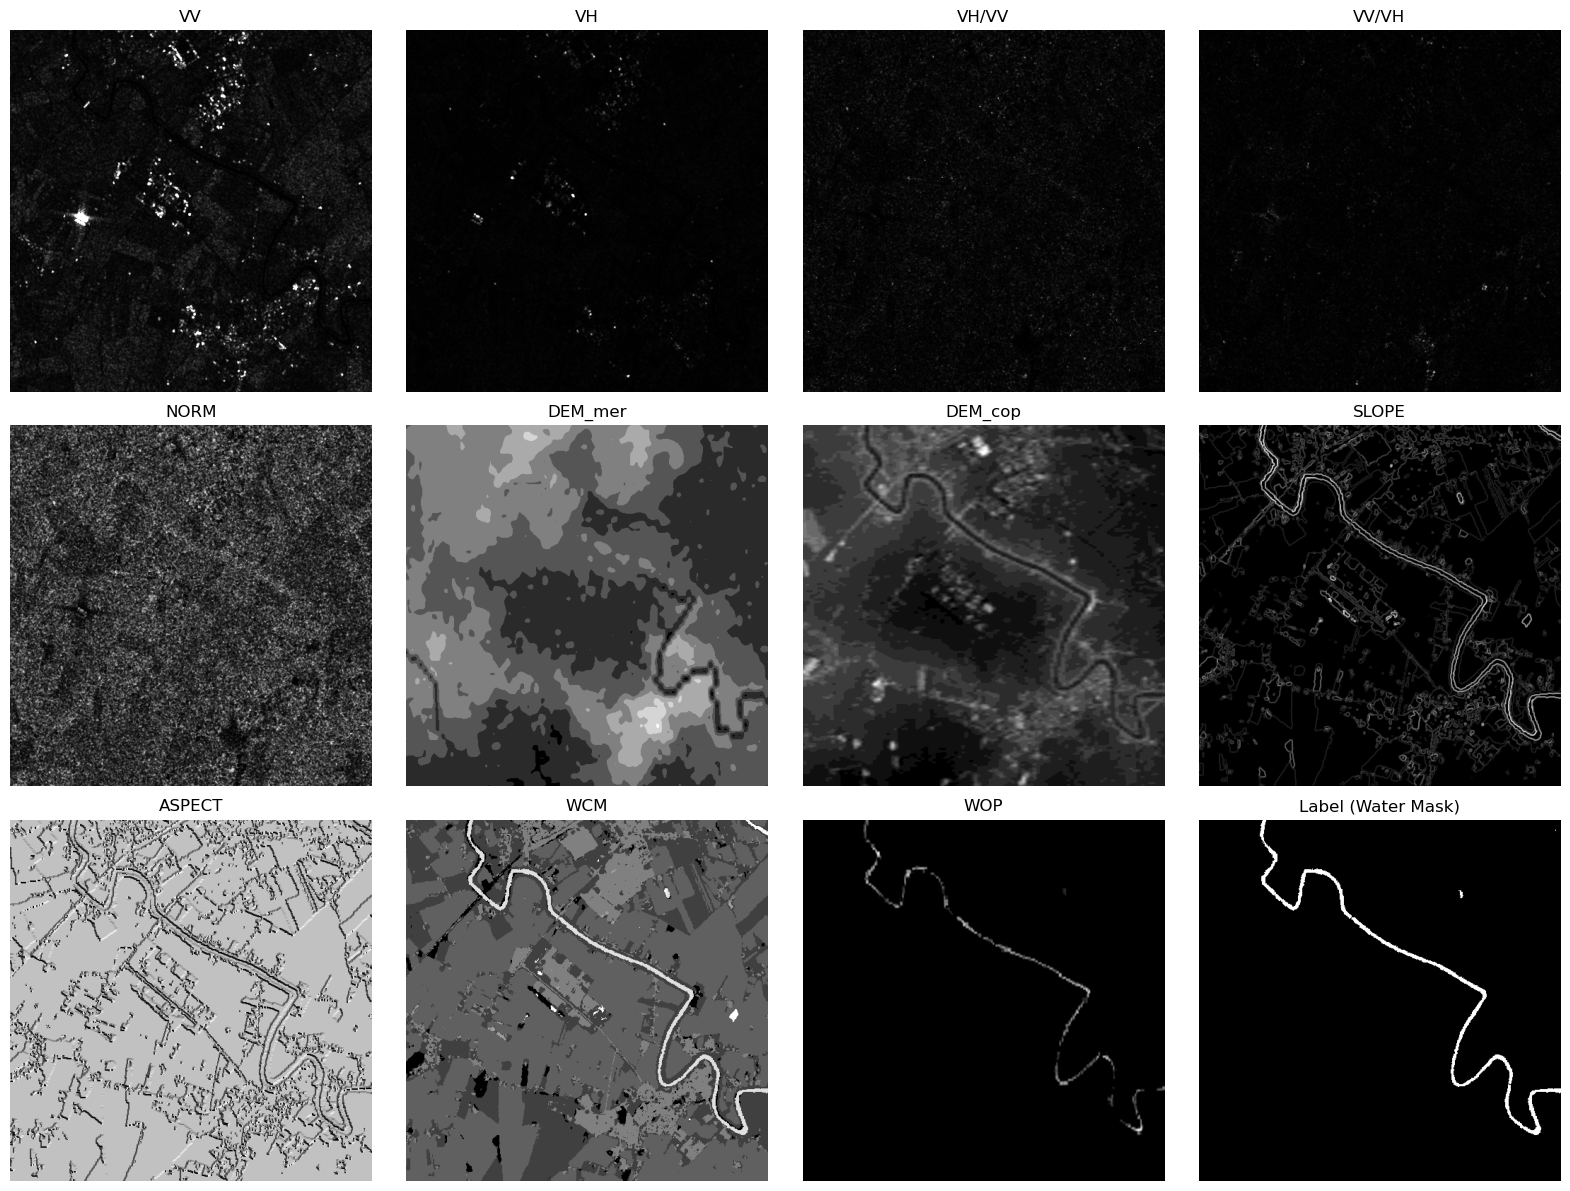

In [6]:
# Features visualization
image_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/images'
label_dir = 'C:/Users/maria/Documents/01_Teledeteccion/04_AEI/00_Practicas/Trabajo/Inputs/train/labels' 

# Select the number of images to be processed
n = int(input("Select image number (value between 0 y 1630): "))

vz.visualize_features(n, image_dir,label_dir)

In [7]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,42729472.0,1704.468018,2562.775391,0.0,669.000000,1147.000000,1888.000000,3.276500e+04
VH,42729472.0,377.341156,698.837891,0.0,157.000000,272.000000,441.000000,3.276500e+04
VH_VV,42728074.0,inf,NaN,0.0,0.137107,0.237258,0.399858,inf
VV_VH,42728074.0,inf,NaN,0.0,2.500888,4.214815,7.293556,inf
NORM,42728074.0,-0.569935,0.295390,-1.0,-0.758849,-0.616477,-0.428716,1.000000e+00
DEM_mer,42729472.0,-124.271004,1601.768799,-9999.0,24.000000,60.000000,121.000000,2.501000e+03
DEM_cop,42729472.0,130.470963,262.312988,-4.0,24.000000,61.000000,122.000000,2.487000e+03
SLOPE,42729472.0,218.437744,438.445557,0.0,0.000000,0.000000,176.776703,5.031153e+03
ASPECT,42729472.0,245.103699,67.569313,0.0,270.000000,270.000000,270.000000,3.581524e+02
WCM,42729472.0,31.681793,17.076439,0.0,10.000000,30.000000,40.000000,1.000000e+02


In [8]:
# Percentage of NaN values per feature
nan_percent = (X.isna().sum() / len(X)) * 100
nan_percent = nan_percent.sort_values(ascending=False)  

nan_percent

VH_VV      0.003272
VV_VH      0.003272
NORM       0.003272
VV         0.000000
VH         0.000000
DEM_mer    0.000000
DEM_cop    0.000000
SLOPE      0.000000
ASPECT     0.000000
WCM        0.000000
WOP        0.000000
dtype: float64

Primeras conclusiones:
- El DEM de Meris presenta valores -9999 que se corresponden con valores No data

- El DEM de Copernicus presenta valores negativos, que no tienen sentido físico, hay que eliminarlos o substituirlos (imputación con nuevos valores)

- Variable WCM tiene valores 0.0 que se corresponden con valores No Data conforme información del dataset

- Variable WOP tiene valores >100 que se corresponden con valores No Data conforme información del dataset

#### 2.2 Data cleaning

##### 2.2.1 Remove inf and Na values

In [4]:
# Remove NaN and infinite values
X_clean = X.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
y_clean = y.loc[X_clean.index].reset_index(drop=True)

In [5]:
X_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,42577931.0,1709.858887,2566.413086,1.000000,674.000000,1152.000000,1891.000000,32765.000000
VH,42577931.0,378.680389,699.968018,1.000000,158.000000,273.000000,442.000000,32765.000000
VH_VV,42577931.0,0.321469,0.337382,0.000061,0.138024,0.238036,0.400397,147.000000
VV_VH,42577931.0,6.557336,13.419886,0.006803,2.497521,4.201047,7.245098,16382.500000
NORM,42577931.0,-0.568673,0.293084,-0.999878,-0.757432,-0.615462,-0.428166,0.986486
DEM_mer,42577931.0,-124.962204,1604.407593,-9999.000000,25.000000,60.000000,121.000000,2501.000000
DEM_cop,42577931.0,130.682297,262.735229,-4.000000,24.000000,61.000000,122.000000,2487.000000
SLOPE,42577931.0,218.955933,438.751251,0.000000,0.000000,0.000000,176.776703,5031.152832
ASPECT,42577931.0,245.035767,67.653511,0.000000,270.000000,270.000000,270.000000,358.152405
WCM,42577931.0,31.556120,16.919479,0.000000,10.000000,30.000000,40.000000,100.000000


In [6]:
print(X_clean.shape)
print(y_clean.shape)

(42577931, 11)
(42577931, 1)


##### 2.2.2 Remove No Data values (WCM & WOP)

In [7]:
# Drop rows with No Data Values for WCM and WOP columns
X_clean, y_clean = dP.drop_NoData_rows(X_clean, y_clean)

In [8]:
print(X_clean.shape)
print(y_clean.shape)

(42309821, 11)
(42309821, 1)


In [9]:
X_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,42309821.0,1716.817383,2572.816406,1.000000,679.000000,1157.000000,1898.000000,32765.000000
VH,42309821.0,379.908417,701.937988,1.000000,159.000000,274.000000,443.000000,32765.000000
VH_VV,42309821.0,0.321059,0.337545,0.000061,0.137741,0.237611,0.400000,147.000000
VV_VH,42309821.0,6.572161,13.457809,0.006803,2.500000,4.208556,7.260000,16382.500000
NORM,42309821.0,-0.569140,0.292001,-0.999878,-0.757869,-0.616016,-0.428571,0.986486
DEM_mer,42309821.0,-126.304848,1609.243164,-9999.000000,24.000000,59.000000,121.000000,2501.000000
DEM_cop,42309821.0,130.873245,263.383057,-4.000000,24.000000,61.000000,122.000000,2487.000000
SLOPE,42309821.0,220.321548,439.586578,0.000000,0.000000,0.000000,176.776703,5031.152832
ASPECT,42309821.0,244.877274,69.977242,0.000000,270.000000,270.000000,270.000000,358.152405
WCM,42309821.0,31.745090,16.757149,10.000000,10.000000,30.000000,40.000000,100.000000


### 3. Train-test split

In [10]:
#Seleccionamos train y test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state= 43, stratify=y_clean) 

print(X_train.shape)
print(y_train.shape)

(33847856, 11)
(33847856, 1)


### 4. Variable target

In [17]:
y_train.value_counts(normalize=True)*100

Labels
0.0       91.559569
1.0        8.440431
Name: proportion, dtype: float64

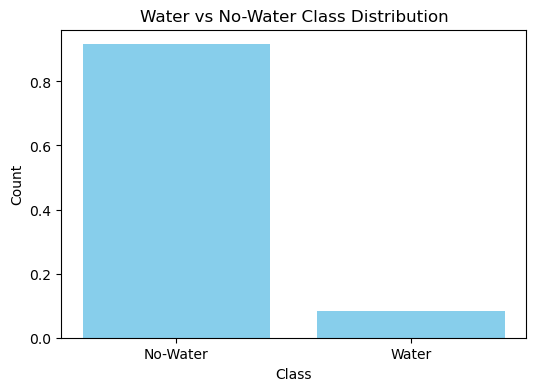

In [18]:
# Calculate frequency of each class
label_freq = y_train['Labels'].value_counts(normalize=True).sort_index()

# Create mapping
label_names = {0.0: 'No-Water', 1.0: 'Water'}
label_names_list = [label_names[val] for val in label_freq.index]

# Plot
plt.figure(figsize=(6,4))
plt.bar(label_names_list, label_freq.values, color='skyblue')
plt.title('Water vs No-Water Class Distribution')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

Las clases están muy desbalanceadas, siendo la clase target o positiva (water) la de menor proporción

### 5. Features

#### 5.1 Univariate analysis

In [19]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 33847856 entries, 16092565 to 406388
Data columns (total 11 columns):
 #   Column   Dtype  
---  ------   -----  
 0   VV       float32
 1   VH       float32
 2   VH_VV    float32
 3   VV_VH    float32
 4   NORM     float32
 5   DEM_mer  float32
 6   DEM_cop  float32
 7   SLOPE    float32
 8   ASPECT   float32
 9   WCM      float32
 10  WOP      float32
dtypes: float32(11)
memory usage: 1.6 GB


In [20]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
VV,33847856.0,1717.066650,2566.529053,1.000000,679.000000,1157.000000,1899.000000,32765.000000
VH,33847856.0,379.994537,704.416016,1.000000,159.000000,274.000000,443.000000,32765.000000
VH_VV,33847856.0,0.321050,0.336083,0.000061,0.137755,0.237624,0.400000,147.000000
VV_VH,33847856.0,6.572366,13.594566,0.006803,2.500000,4.208333,7.259259,16382.500000
NORM,33847856.0,-0.569134,0.253426,-0.999878,-0.757848,-0.616000,-0.428571,0.986486
DEM_mer,33847856.0,-126.262199,1601.978516,-9999.000000,24.000000,59.000000,121.000000,2500.000000
DEM_cop,33847856.0,130.862137,263.323151,-4.000000,24.000000,61.000000,122.000000,2487.000000
SLOPE,33847856.0,220.279053,440.503082,0.000000,0.000000,0.000000,176.776703,5031.152832
ASPECT,33847856.0,244.883179,66.446922,0.000000,270.000000,270.000000,270.000000,358.152405
WCM,33847856.0,31.745871,16.899700,10.000000,10.000000,30.000000,40.000000,100.000000


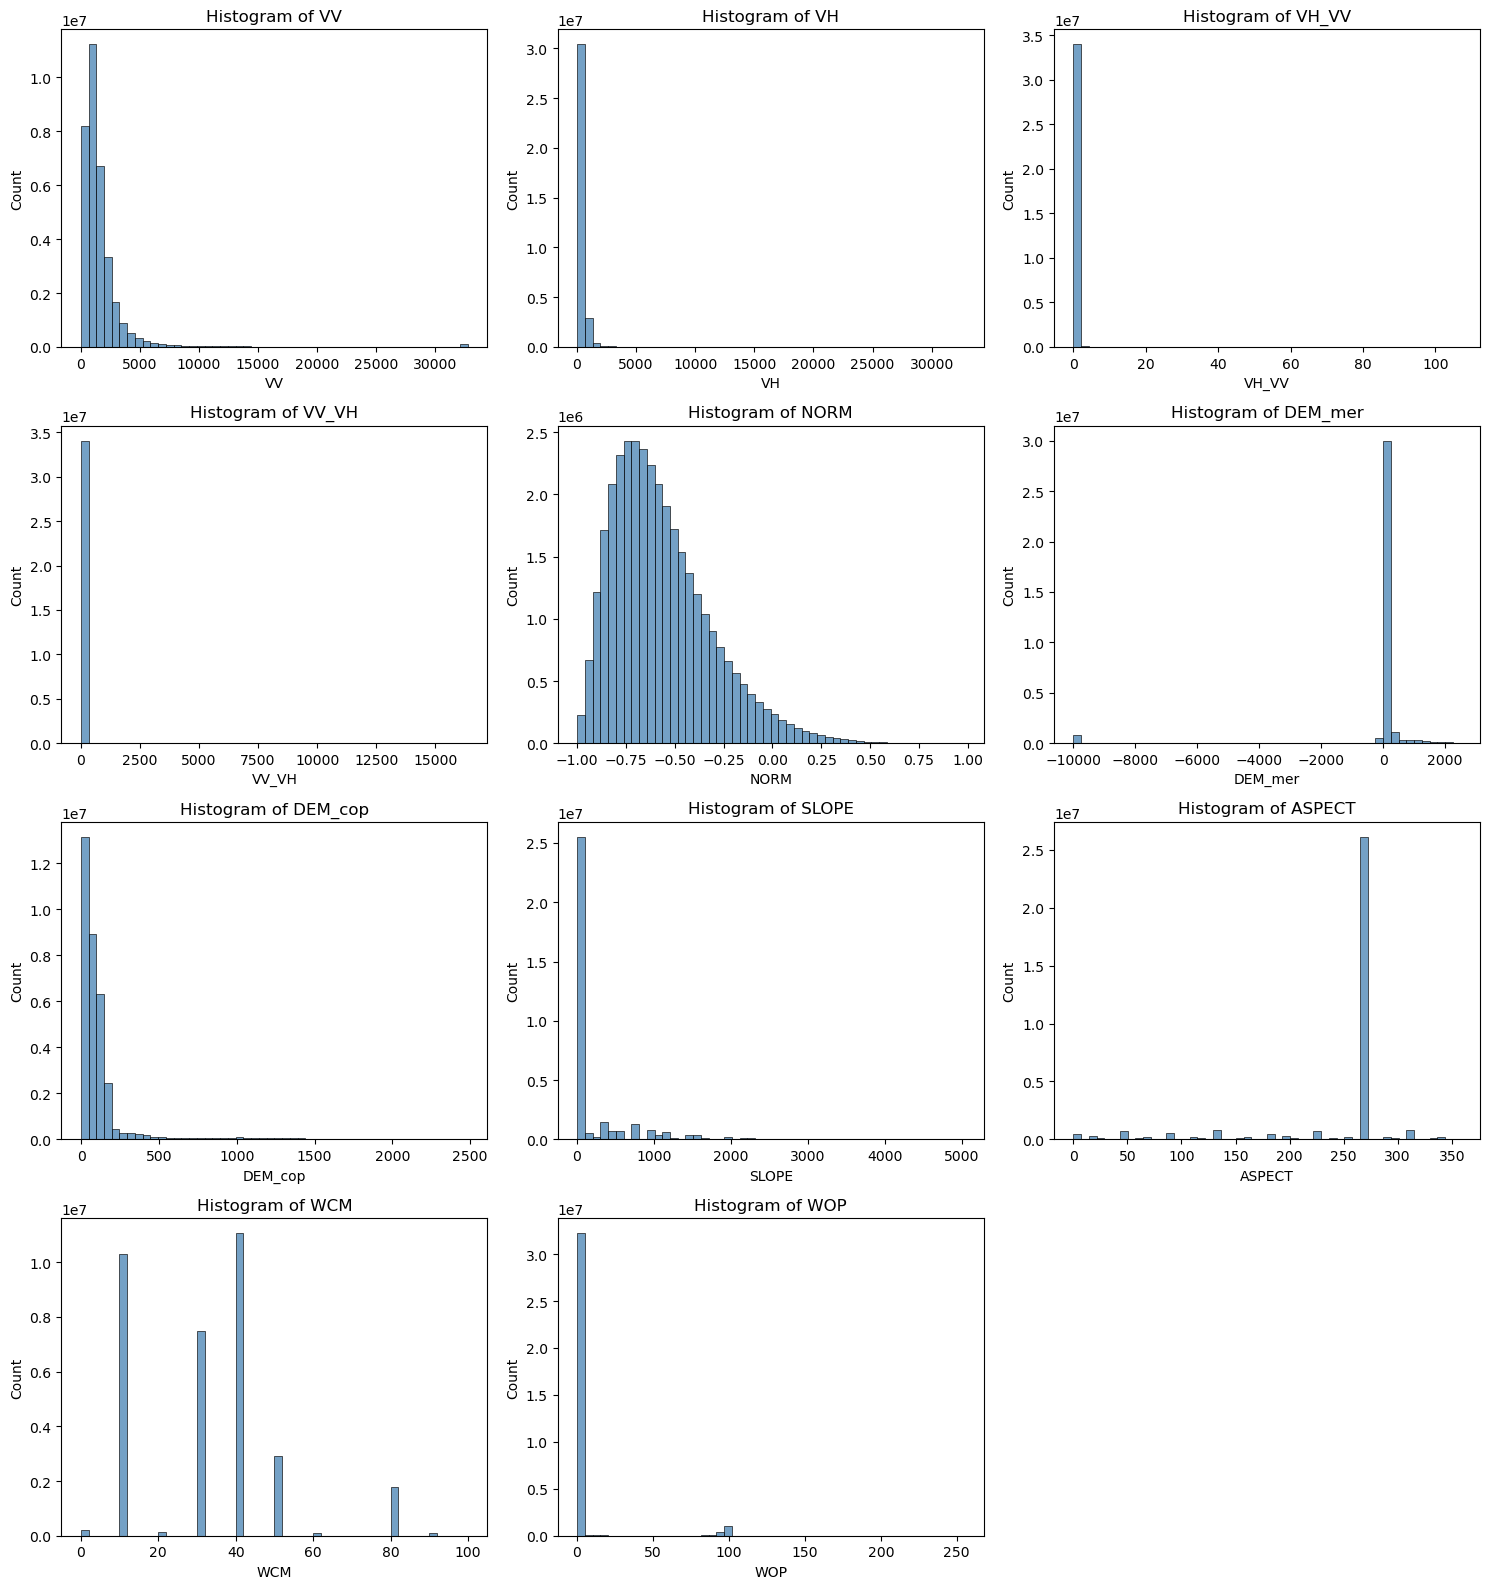

In [23]:
# Feature histograms
vz.plot_feature_histograms(X_train)


##### Conclusiones & Próximos pasos

1. Seleccionar un DEM y eliminar los valores negativos

2. La feature WCM es categórica. Se va a  introducir al modelo como una numérica, aplicando StandardScaler

3. El valor predominante en WOP es 0, que significa 0% de probabilidad de ocurrencia de agua. Distribución similar a la de la variable target

4. Predominan superficies de baja cota (valores DEM próximos a 0) y sin pendiente (valores de pendiente próximos a 0)

5. Los valores de pendientes elevados, corresponden con acantilados o edificios (ej: un valor de 5000 equivale a unos 88º, lo que se corresponde con una pared vertical)

6. La variable aspect indica la orientación de la pendiente. El valor 270 de aspecto se corresponde con un valor dummy asignado por richdem a las superficies planas (librería con la que se ha calculado pendiente y orientación/aspect). No se va a introducir al modelo, puesto que 1) en los modelos de Machine Learning no ha mostrado tener mucha importancia; 2) para incluirla en el modelo, como numérica, hay que hacer transformaciones de sin/cos dado que es una variable con valores cíclicos entre 0º y 360º, y no se puede tratar con StandardScaler como una variable lineal

#### 5.2 Features categóricas: Análisis bivariante con el target

##### 5.2.1 Feature engineering: categorical derived features

In [9]:
# Feature aspect binning transformation
X_train = dP.bin_aspect_to_direction(X_train)

In [10]:
X_train.ORIENT.value_counts()

ORIENT
Flat    26085854
E        1143132
NW       1109922
SE       1103004
N        1059396
S        1030556
NE        985222
SW        976007
W         569251
Name: count, dtype: int64

In [ ]:
# Feature WMC
X_train = dP.map_wcm_classes_no_drop(X_train)

X_train.WCM_LABEL.value_counts(normalize=True)*100

WCM_LABEL
Cropland                    32.478164
Tree cover                  30.194270
Grassland                   21.964854
Built-up                     8.583297
Permanent water bodies       5.199613
No Data                      0.615404
Shrubland                    0.401631
Bare / sparse vegetation     0.285159
Herbaceous wetland           0.272342
Moss and lichen              0.005044
Snow and ice                 0.000223
Name: proportion, dtype: float64

In [12]:
# Drop 'No Data' from X_train and reset index
mask_train = X_train['WCM_LABEL'] != 'No Data'
X_train = X_train[mask_train].reset_index(drop=True)
y_train = y_train[mask_train].reset_index(drop=True)

In [ ]:
# Create a df for plotting and statistical analysis
y_labeled = y_train.copy()
y_labeled['Label'] = y_labeled[y_train.columns[0]].map({0: 'No-Water', 1: 'Water'})
y_labeled['Label_num'] = y_labeled[y_train.columns[0]]
df = pd.concat([X_train, y_labeled[['Label','Label_num']]], axis=1)

##### 5.2.2 Viz

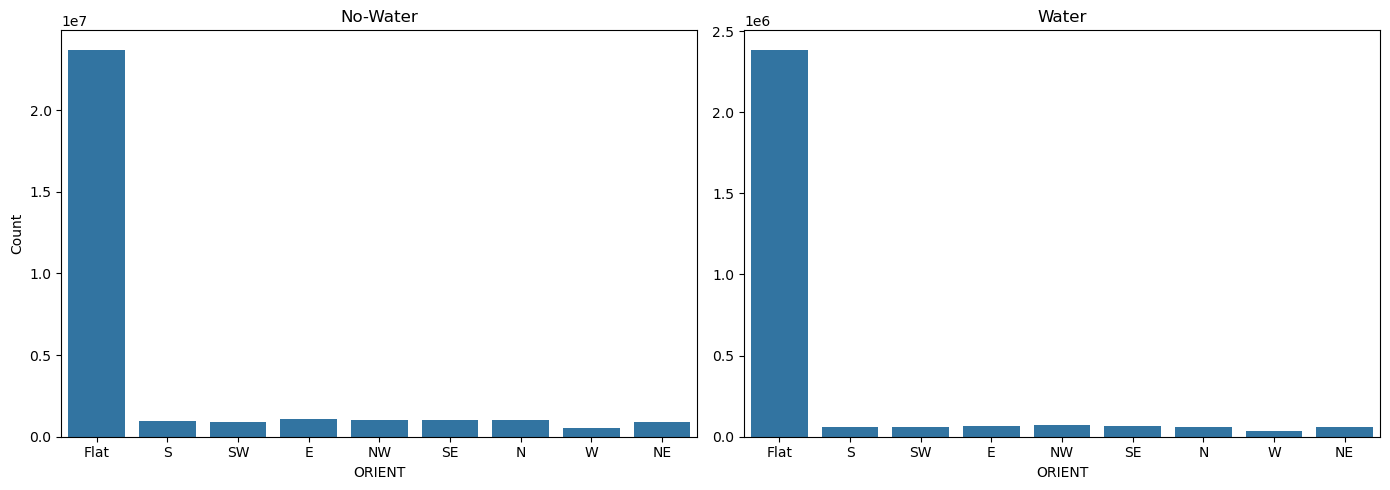

In [ ]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
orient_order = df['ORIENT'].unique().tolist()  # or sort manually if preferred

# Plot No-Water
sns.countplot(x='ORIENT', data=df[df['Label'] == 'No-Water'], ax=axes[0], order=orient_order)
axes[0].set_title('No-Water')
axes[0].set_xlabel('ORIENT')
axes[0].set_ylabel('Count')

# Plot Water
sns.countplot(x='ORIENT', data=df[df['Label'] == 'Water'], ax=axes[1], order=orient_order)
axes[1].set_title('Water')
axes[1].set_xlabel('ORIENT')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Las distribuciones de ORIENT son similares tanto en zonas inundadas como no inundadas por lo que no parece una feature muy informativa

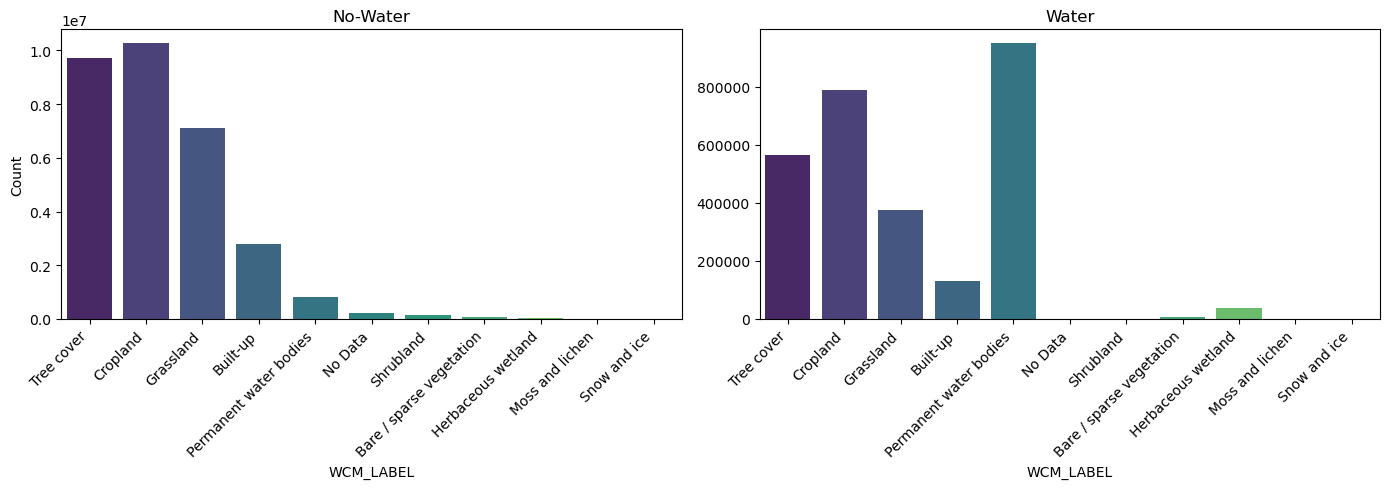

In [ ]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
wcm_order = df['WCM_LABEL'].dropna().unique().tolist()  # or sort manually if preferred

# Plot No-Water
sns.countplot(x='WCM_LABEL', data=df[df['Label'] == 'No-Water'], ax=axes[0], order=wcm_order,palette='viridis')
axes[0].set_title('No-Water')
axes[0].set_xlabel('WCM_LABEL')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
# axes[0].tick_params(axis='x', rotation=45)

# Plot Water
sns.countplot(x='WCM_LABEL', data=df[df['Label'] == 'Water'], ax=axes[1], order=wcm_order, palette='viridis')
axes[1].set_title('Water')
axes[1].set_xlabel('WCM_LABEL')
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
# axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

##### 5.2.3 Statistical test

In [ ]:
# Chi-squared test for ORIENT
contingency_orient = pd.crosstab(df['ORIENT'], df['Label_num'])
chi2_orient, p_orient, _, _ = chi2_contingency(contingency_orient)

# Chi-squared test for WCM_LABEL
contingency_wcm = pd.crosstab(df['WCM_LABEL'], df['Label_num'])
chi2_wcm, p_wcm, _, _ = chi2_contingency(contingency_wcm)

# Results
print(f"Chi-squared test for ORIENT vs Target:")
print(f"  Chi2 = {chi2_orient:.2f}, p-value = {p_orient:.4f}")

print(f"\nChi-squared test for WCM_LABEL vs Target:")
print(f"  Chi2 = {chi2_wcm:.2f}, p-value = {p_wcm:.4f}")

Chi-squared test for ORIENT vs Target:
  Chi2 = 84755.05, p-value = 0.0000

Chi-squared test for WCM_LABEL vs Target:
  Chi2 = 5118084.65, p-value = 0.0000


In [16]:
contingency_orient

Label_num,0.0,1.0
ORIENT,,
E,1077592,65540
Flat,23491748,2384494
N,997738,61658
NE,926844,58374
NW,1040127,69794
S,970280,60272
SE,1035075,67929
SW,918560,57447
W,536179,33072


#### 5.3 Features numéricas: análisis bivariante con el target

##### 5.3.1 DEM negative values treatment

In [17]:
# Analysis of the negative values in the DEMs
DEM_meris_percent_negative = (X_train['DEM_mer'] < 0).mean() * 100
print(f"Percentage of negative DEM_meris values: {DEM_meris_percent_negative:.2f}%")

DEM_cop_percent_negative = (X_train['DEM_cop'] < 0).mean() * 100
print(f"Percentage of negative DEM_cop values: {DEM_cop_percent_negative:.2f}%")

Percentage of negative DEM_meris values: 2.55%
Percentage of negative DEM_cop values: 0.66%


In [18]:
# Replace negative values in DEM_cop with values from DEM_mer
X_train['DEM_cop_filled'] = X_train['DEM_cop'].where(X_train['DEM_cop'] >= 0, X_train['DEM_mer'])
X_train['DEM_cop_filled'] = X_train['DEM_cop_filled'].apply(lambda x: x if x >= 0 else 0)


In [19]:
DEM_cop_percent_negative = (X_train['DEM_cop_filled'] < 0).mean() * 100
print(f"Percentage of negative DEM_cop_filled values: {DEM_cop_percent_negative:.2f}%")

Percentage of negative DEM_cop_filled values: 0.00%


In [20]:
# sns.boxplot(x=X_train['DEM_cop_filled'], color='steelblue',whis=3)

##### 5.3.2 WOP values

In [33]:
# Values > 100 mean No Data
X_train[X_train['WOP']>100].value_counts().sum()

4740

In [34]:
# Delete rows with WOP > 100
mask = X_train['WOP'] <= 100
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

In [35]:
num_features = ['VV','VH','VH_VV','VV_VH','NORM','DEM_cop_filled','SLOPE','WOP']

In [36]:
# Create a df for plotting and statistical analysis
y_labeled = y_train.copy()
y_labeled['Label'] = y_labeled[y_train.columns[0]].map({0: 'No-Water', 1: 'Water'})
y_labeled['Label_num'] = y_labeled[y_train.columns[0]]
df = pd.concat([X_train, y_labeled[['Label','Label_num']]], axis=1)

##### 5.3.3 Visual analysis

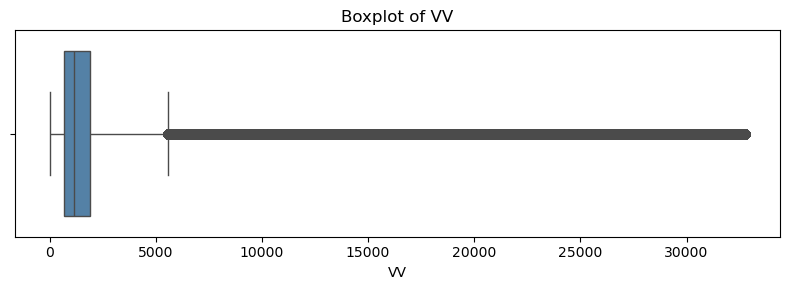

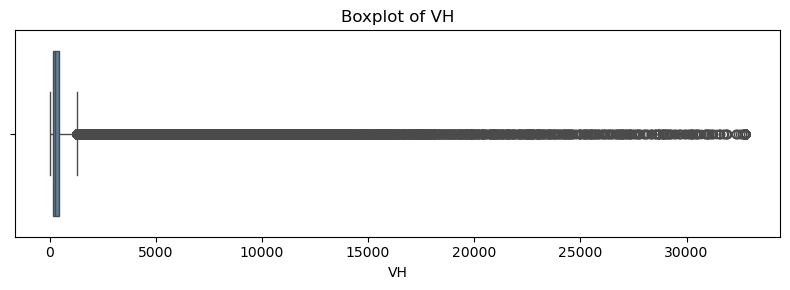

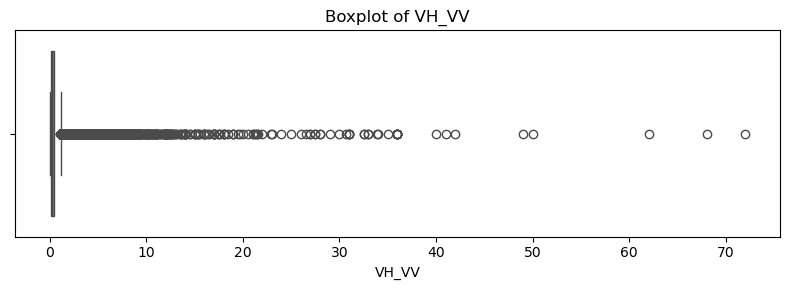

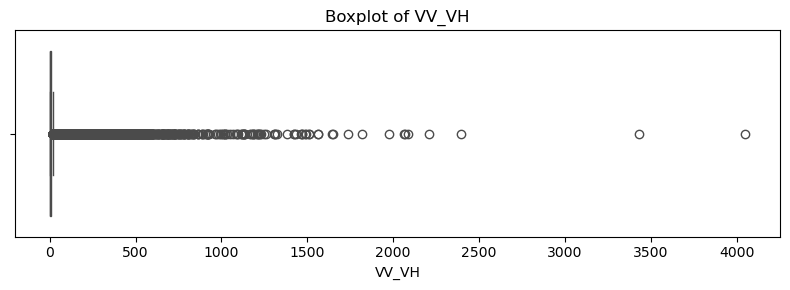

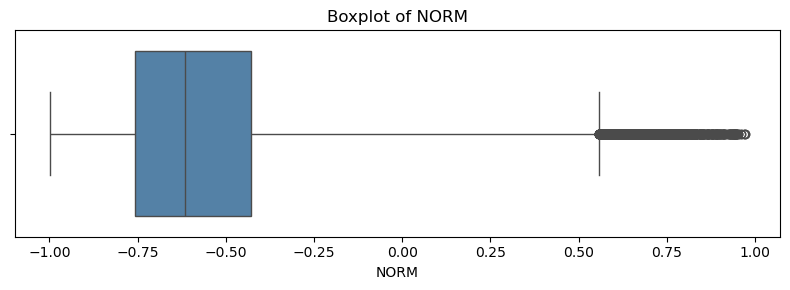

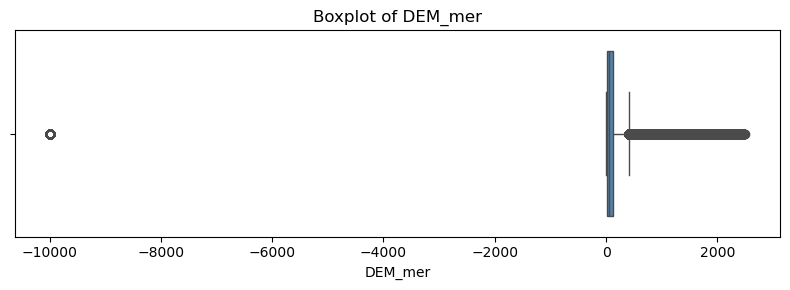

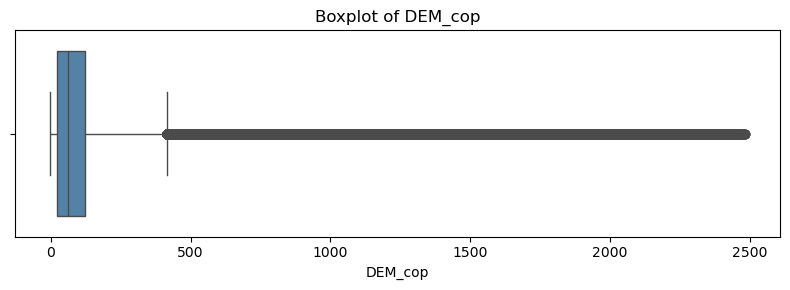

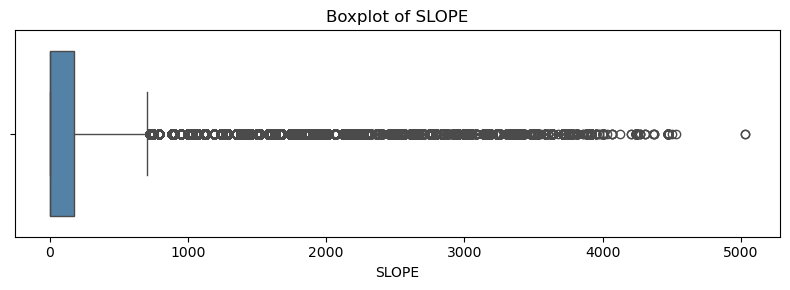

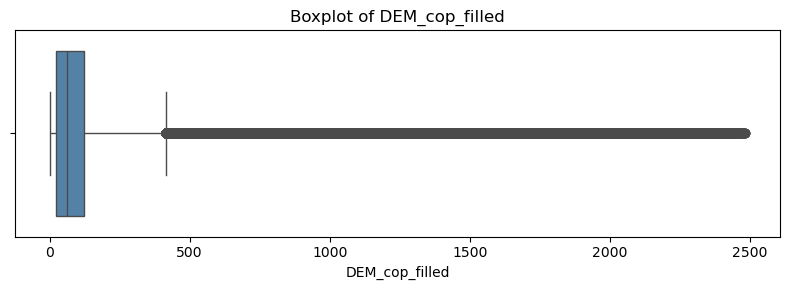

In [43]:
# Boxplot of the numerical features
X_sample = X_train.sample(n=3000000, random_state=42) #10% of the data

# Plot one boxplot per feature
for col in num_features:
    plt.figure(figsize=(8, 3))
    sns.boxplot(x=X_sample[col], color='steelblue',whis=3)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


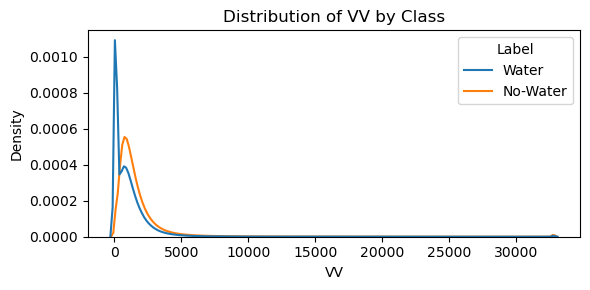

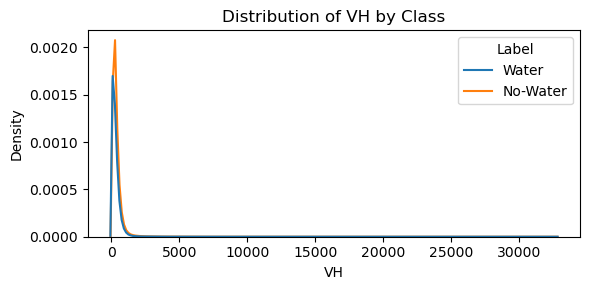

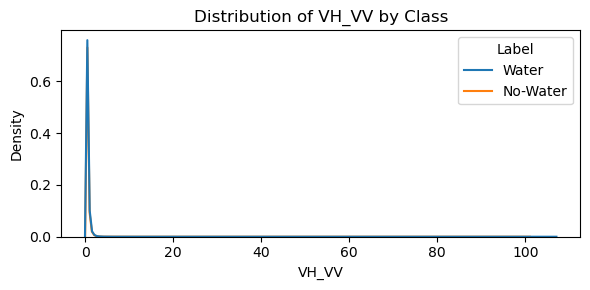

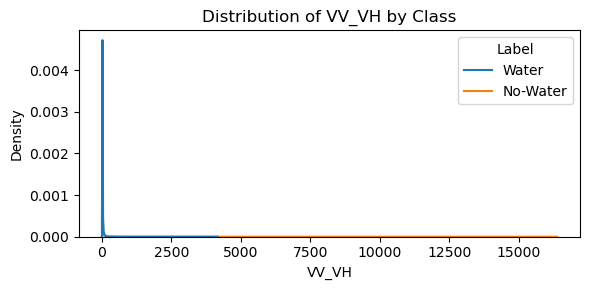

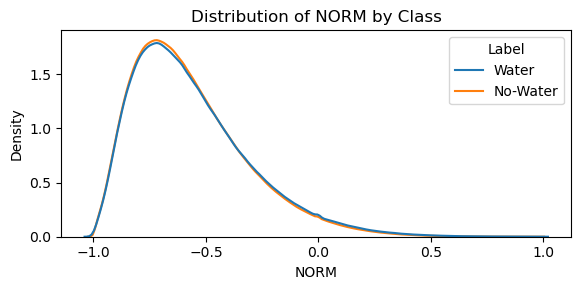

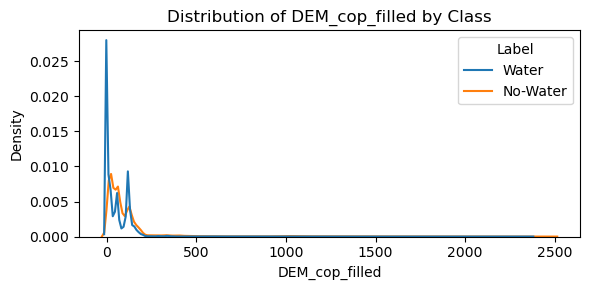

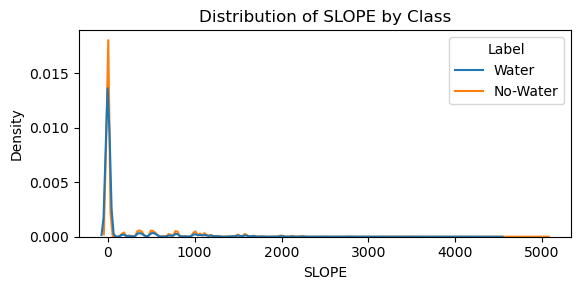

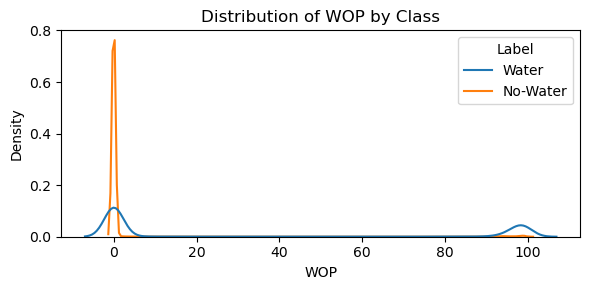

In [38]:
X_sample = df.sample(n=50000, random_state=42) #10% of the data
# KDE plot of the numerical features
for col in num_features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=df, x=col, hue='Label', common_norm=False)
    plt.title(f'Distribution of {col} by Class')
    plt.tight_layout()
    plt.show()


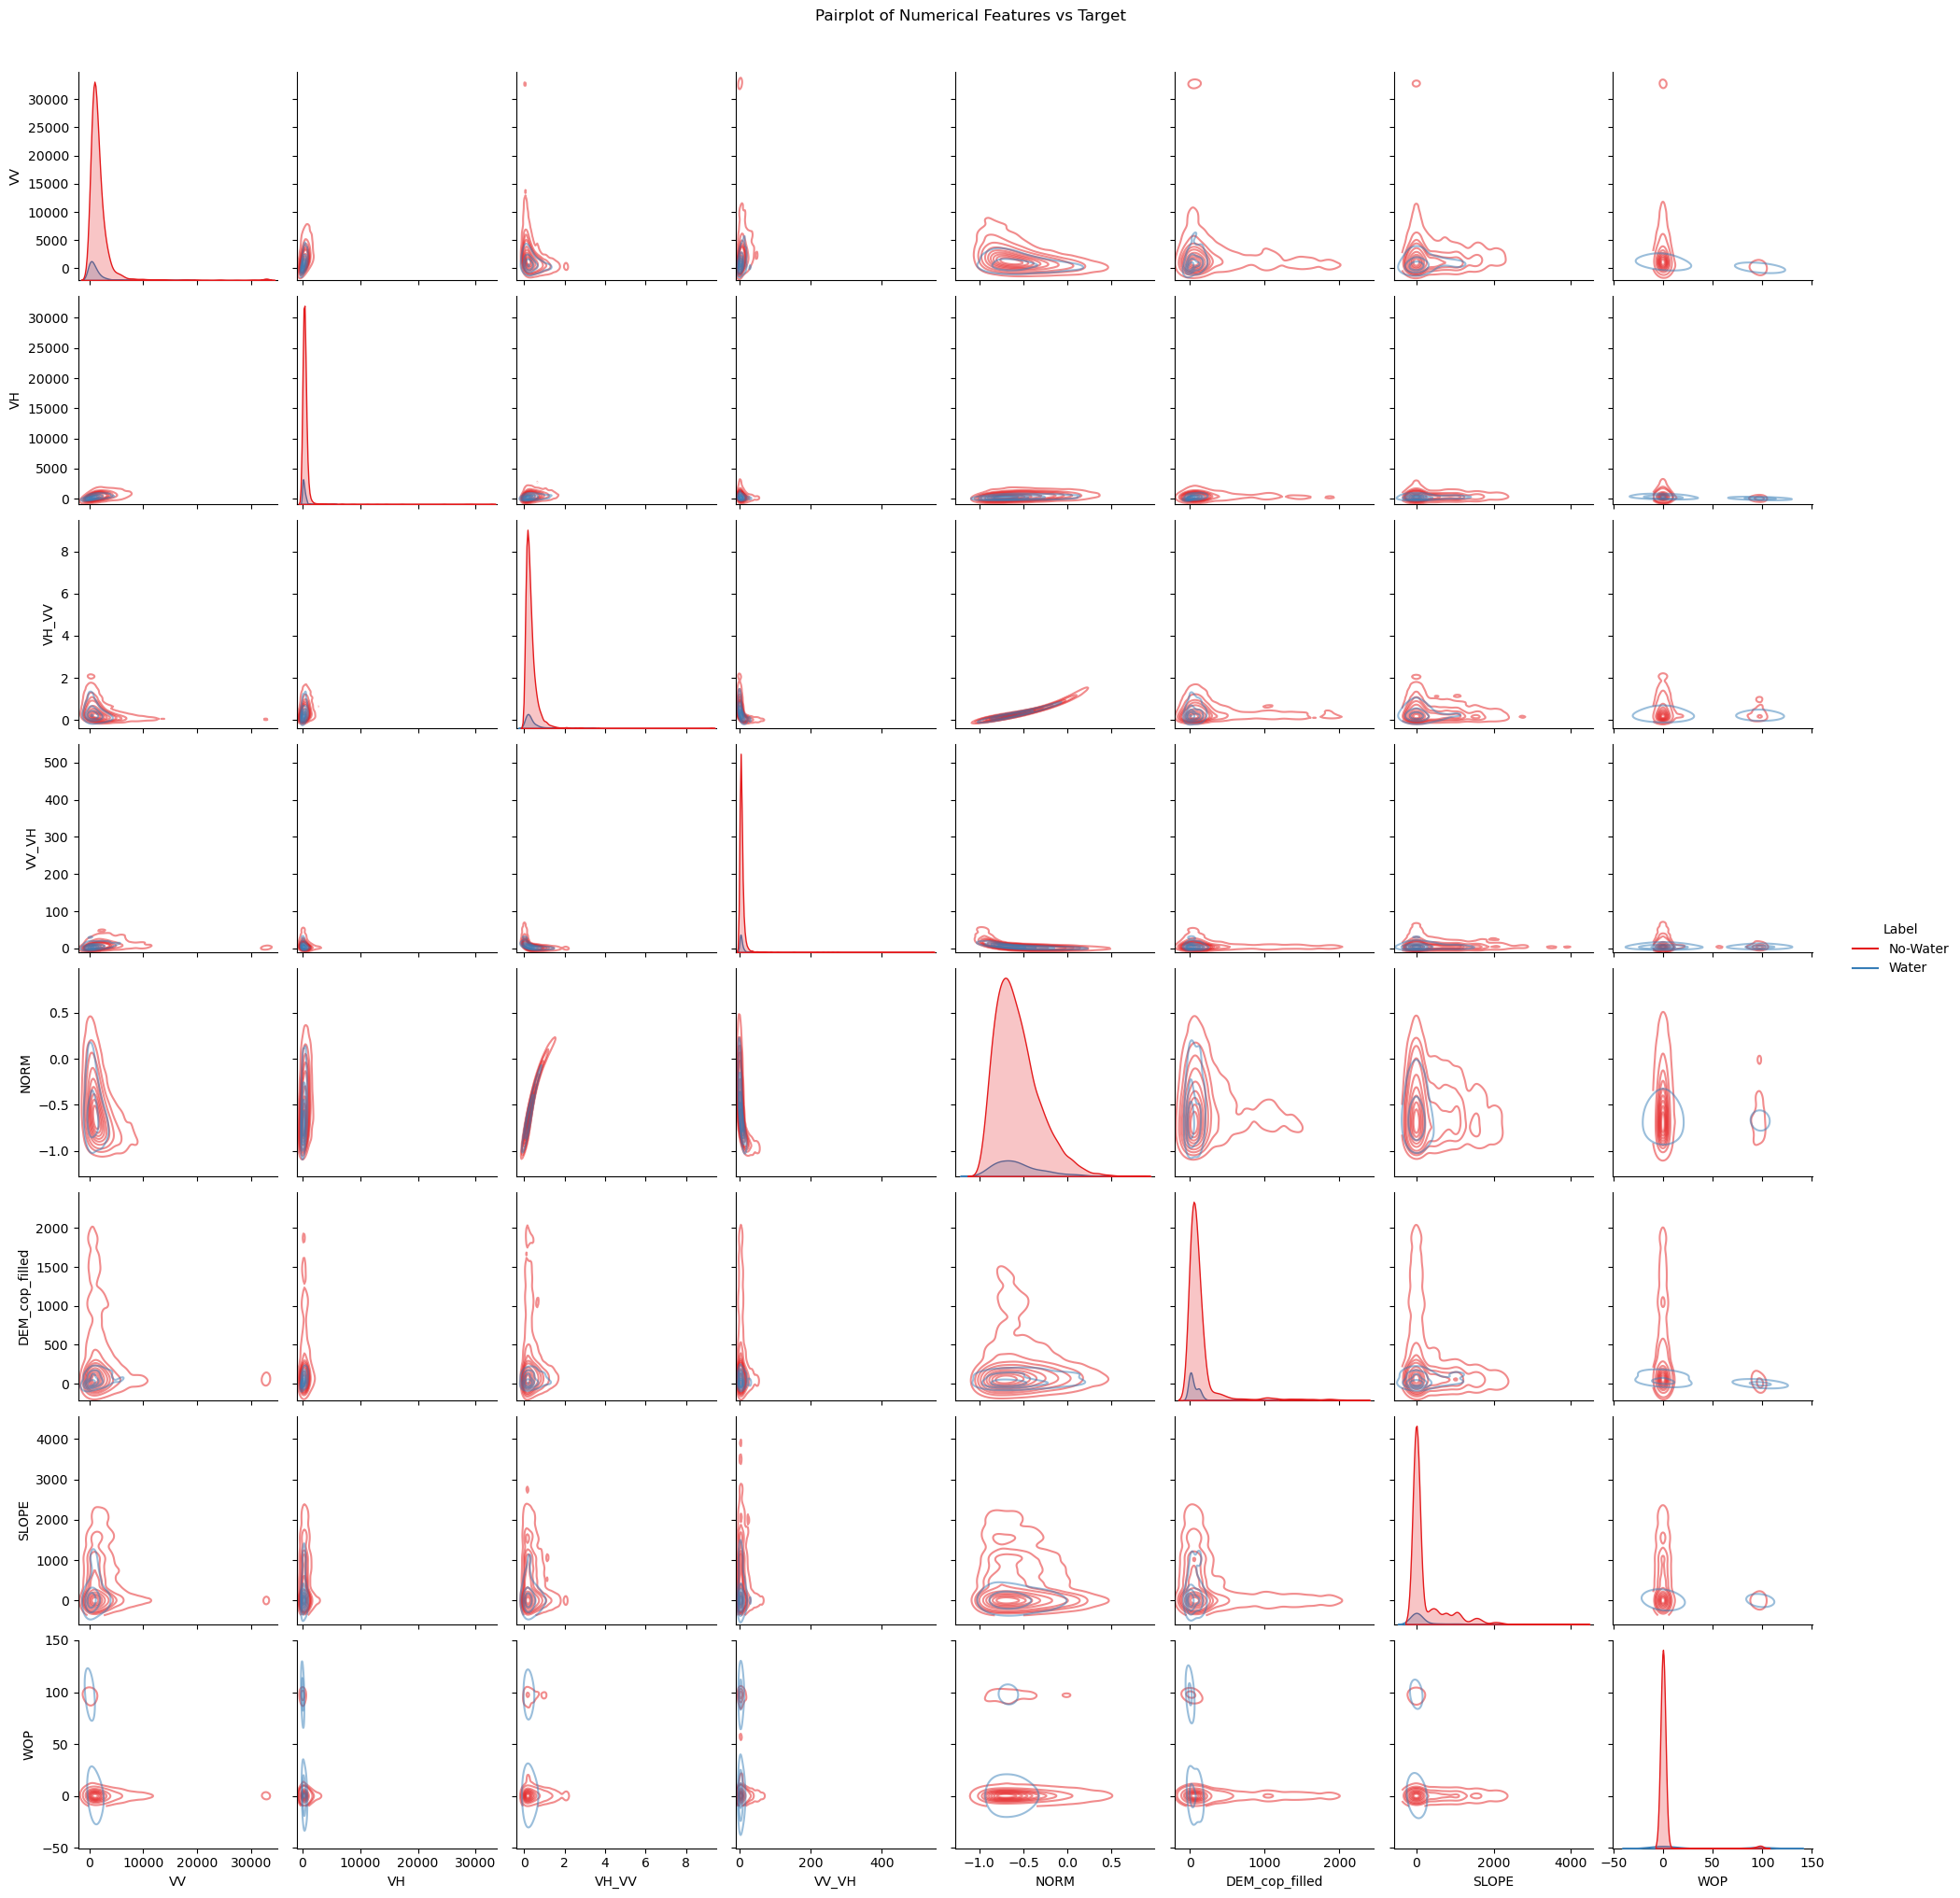

In [37]:
# Create a df for plotting
X_sample = df.sample(n=5000, random_state=42)

# Plot
sns.pairplot(data=X_sample[num_features + ['Label']],
             hue='Label',
             palette='Set1',
             plot_kws={'alpha': 0.5, 's': 20},  # s = marker size
             kind='kde') 

plt.suptitle("Pairplot of Numerical Features vs Target", y=1.02)
plt.show()

##### 5.3.4. Statistical test

In [39]:
# Mann-Whitney U test for numerical features to test for significant differences between classes
results = [] #  DataFrame to store results

for col in num_features:
    group_0 = df[df['Label'] == 'No-Water'][col]
    group_1 = df[df['Label'] == 'Water'][col]
    
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    results.append({'Feature': col, 'U_statistic': stat, 'p_value': p})


u_test_results = pd.DataFrame(results).sort_values(by='p_value') # Results to DataFrame

print(u_test_results) # Show results

          Feature   U_statistic  p_value
0              VV  5.947295e+13      0.0
1              VH  5.921278e+13      0.0
2           VH_VV  4.366875e+13      0.0
3           VV_VH  4.489649e+13      0.0
4            NORM  4.366875e+13      0.0
5  DEM_cop_filled  5.975574e+13      0.0
6           SLOPE  4.783732e+13      0.0
7             WOP  2.949873e+13      0.0


#### 5.4 Features transformations

In [11]:
X_train

,VV,VH,VH_VV,VV_VH,NORM,DEM_mer,DEM_cop,SLOPE,ASPECT,WCM,WOP
16092565,1075.0,220.0,0.204651,4.886364,-0.660232,32.0,33.0,0.000000,270.000000,50.0,0.0
14612009,1570.0,191.0,0.121656,8.219895,-0.783078,125.0,149.0,0.000000,270.000000,10.0,0.0
4737917,1090.0,218.0,0.200000,5.000000,-0.666667,1713.0,1707.0,0.000000,270.000000,10.0,0.0
33275942,2513.0,426.0,0.169519,5.899061,-0.710105,59.0,66.0,0.000000,270.000000,10.0,0.0
15791951,325.0,19.0,0.058462,17.105263,-0.889535,-9999.0,0.0,0.000000,270.000000,80.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...
21409960,420.0,136.0,0.323810,3.088235,-0.510791,43.0,43.0,0.000000,270.000000,40.0,0.0
10366608,1340.0,629.0,0.469403,2.130366,-0.361097,150.0,166.0,0.000000,270.000000,10.0,0.0
27462272,1140.0,761.0,0.667544,1.498029,-0.199369,460.0,455.0,395.284698,251.565048,10.0,0.0
13715189,1331.0,318.0,0.238918,4.185534,-0.614312,126.0,125.0,500.000000,180.000000,30.0,0.0


In [12]:
# ------------------- Num preprocessing pipeline ----------------------------#
# Define feature groups
log_features = ['VV', 'VH', 'VH_VV', 'VV_VH', 'NORM', 'DEM_cop_filled', 'SLOPE', 'WOP']
scale_only_features = ['ASPECT', 'WCM']


# Apply the function for cleaning DEM 
DEM_filled = FunctionTransformer(dP.DEM_filled,validate=False)

# Pipeline: log + scale
log_and_scale_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scale', StandardScaler())
])

# Pipeline: scale only
scale_only_pipeline = Pipeline([
    ('scale', StandardScaler())
])

# Full column-wise transformation
numeric_column_transform = ColumnTransformer([
    ('log_scale', log_and_scale_pipeline, log_features),
    ('scale_only', scale_only_pipeline, scale_only_features)
], remainder='drop')

# Final numerical preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('DEM_fill', DEM_filled),
    ('transform', numeric_column_transform)
])

In [13]:
X_train_preproc = preprocessing_pipeline.fit_transform(X_train)
X_test_preproc = preprocessing_pipeline.transform(X_test)

In [14]:
# Manually construct names as per transformer names
log_cols = [f"log_scale__{col}" for col in log_features]
scale_cols = [f"scale_only__{col}" for col in scale_only_features]

# Combine them
final_feature_names = log_cols + scale_cols

# Now convert to DataFrame
X_train_preproc_df = pd.DataFrame(X_train_preproc, columns=final_feature_names, index=X_train.index)
X_test_preproc_df = pd.DataFrame(X_test_preproc, columns=final_feature_names, index=X_test.index)

In [15]:
X_train_preproc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
log_scale__VV,33847856.0,-2.045544e-16,1.0,-6.270939,-0.451884,0.079570,0.573889,3.416595
log_scale__VH,33847856.0,-1.876476e-17,1.0,-4.994780,-0.452473,0.108935,0.605510,5.064160
log_scale__VH_VV,33847856.0,-9.349977e-16,1.0,-1.383594,-0.692149,-0.241162,0.419639,25.402152
log_scale__VV_VH,33847856.0,1.956583e-15,1.0,-2.557343,-0.705580,-0.114826,0.570417,11.854573
log_scale__NORM,33847856.0,-2.962024e-15,1.0,-11.854617,-0.570417,0.114826,0.705580,2.557343
log_scale__DEM_cop_filled,33847856.0,-8.080648e-15,1.0,-2.733649,-0.507035,0.121240,0.595114,2.675201
log_scale__SLOPE,33847856.0,7.743202e-18,1.0,-0.577780,-0.577780,-0.577780,1.226547,2.390907
log_scale__WOP,33847856.0,-5.480363e-17,1.0,-0.243840,-0.243840,-0.243840,-0.243840,4.379379
scale_only__ASPECT,33847856.0,1.728382e-08,1.0,-3.616430,0.370923,0.370923,0.370923,1.672755
scale_only__WCM,33847856.0,-9.477653e-09,1.0,-1.198301,-1.198301,-0.096206,0.454842,3.761127


In [16]:
X_train_preproc_df.head(5)

,log_scale__VV,log_scale__VH,log_scale__VH_VV,log_scale__VV_VH,log_scale__NORM,log_scale__DEM_cop_filled,log_scale__SLOPE,log_scale__WOP,scale_only__ASPECT,scale_only__WCM
16092565,0.006251,-0.117670,-0.385904,0.067051,-0.067051,-0.294337,-0.57778,-0.243840,0.370923,1.005889
14612009,0.384070,-0.263482,-0.768536,0.733940,-0.733940,0.732390,-0.57778,-0.243840,0.370923,-1.198301
4737917,0.020072,-0.127093,-0.406640,0.095469,-0.095469,2.415000,-0.57778,-0.243840,0.370923,-1.198301
33275942,0.853435,0.565042,-0.544555,0.302979,-0.302978,0.174890,-0.57778,-0.243840,0.370923,-1.198301
15791951,-1.185832,-2.607973,-1.079373,1.736876,-1.736877,-2.733649,-0.57778,4.359343,0.370923,2.659032


### 6. MLP

#### 6.1 Training subsample & Feature selection

In [17]:
X_train_preproc_df.shape

(33847856, 10)

In [18]:
y_train.shape

(33847856, 1)

In [19]:
# subsample %
subsample_size = 0.5

# 1% stratified subsample
sss = StratifiedShuffleSplit(n_splits=1, test_size=subsample_size, random_state=42)

for _, sub_idx in sss.split(X_train_preproc_df, y_train):
    X_train_sub = X_train_preproc_df.iloc[sub_idx]
    y_train_sub = y_train.iloc[sub_idx]


In [20]:
print(X_train_sub.shape)
print(y_train_sub.shape)

(16923928, 10)
(16923928, 1)


In [21]:
X_train_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16923928 entries, 8057374 to 14159885
Data columns (total 10 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   log_scale__VV              float64
 1   log_scale__VH              float64
 2   log_scale__VH_VV           float64
 3   log_scale__VV_VH           float64
 4   log_scale__NORM            float64
 5   log_scale__DEM_cop_filled  float64
 6   log_scale__SLOPE           float64
 7   log_scale__WOP             float64
 8   scale_only__ASPECT         float64
 9   scale_only__WCM            float64
dtypes: float64(10)
memory usage: 1.4 GB


In [22]:
# Feature selection
col_to_exclude = input("Cols to exclude, or Esc if not: ").split(',')

features = [col for col in X_train_sub.columns if col not in col_to_exclude]

X_train_sub[features]
X_test_preproc_df[features]

,log_scale__VV,log_scale__VH,log_scale__DEM_cop_filled,log_scale__WOP,scale_only__WCM
28381580,-1.282205,-0.127093,0.566408,-0.24384,0.454842
14136998,-1.152702,-1.435188,2.190703,-0.24384,-1.198301
27652319,0.163051,0.757264,1.221028,-0.24384,-1.198301
20348319,0.392297,1.459504,0.075108,-0.24384,-1.198301
27872674,0.434259,0.596129,0.633402,-0.24384,-1.198301
...,...,...,...,...,...
33401206,-0.779015,-0.452473,0.050834,-0.24384,-0.096206
21015825,0.068299,0.252988,0.718415,-0.24384,-0.096206
40472442,0.176441,0.112697,-0.314987,-0.24384,-1.198301
22515795,0.077844,0.767298,0.643963,-0.24384,-0.096206


In [23]:
# Features selected
print('Features selected:')
print(features)

Features selected:
['log_scale__VV', 'log_scale__VH', 'log_scale__DEM_cop_filled', 'log_scale__WOP', 'scale_only__WCM']


In [24]:
# Numpy transformation for Tensorflow + GPU
X_train_np = X_train_sub[features].to_numpy().astype(np.float32)
X_test_np = X_test_preproc_df.to_numpy().astype(np.float32)

y_train_np = np.array(y_train_sub).astype(np.float32)
y_test_np = np.array(y_test).astype(np.float32)

##### 6.2 MLP construction 

In [25]:
ep = int(input("Nº máximo de épocas:"))
lr = float(input("Learning rate (Default value=0.001):"))
md = float(input("Minima mejora en loss para early stoppin:"))

In [26]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(X_train_sub[features].shape[1],))) # Input Layer

model.add(keras.layers.Dense(units=16, activation = 'relu')) # Dense layer

model.add(keras.layers.Dense(units=8, activation = 'relu')) # Dense layer

model.add(keras.layers.Dense(units=4, activation = 'relu')) # Dense layer

model.add(keras.layers.Dense(units = 1, activation = 'sigmoid')) # Output layer

In [27]:
adam_optimizer = keras.optimizers.Adam(learning_rate= lr, beta_1= 0.9, beta_2 = 0.999)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=md,patience=10)

In [28]:
model.compile(optimizer = adam_optimizer,
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy',Precision(), Recall(), AUC()])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                96        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


#### 6.2 Training

In [30]:
print("Fit model on training data")
history = model.fit(
    X_train_np,
    y_train_np,
    batch_size=256, 
    epochs=ep, 
    validation_split = 0.2,
    callbacks = early_stopping
)

Fit model on training data
Epoch 1/50
52888/52888 [==============================] - 338s 6ms/step - loss: 0.2309 - binary_accuracy: 0.9297 - precision: 0.6806 - recall: 0.3163 - auc: 0.7586 - val_loss: 0.2312 - val_binary_accuracy: 0.9304 - val_precision: 0.6906 - val_recall: 0.3173 - val_auc: 0.7640
Epoch 2/50
52888/52888 [==============================] - 348s 7ms/step - loss: 0.2300 - binary_accuracy: 0.9298 - precision: 0.6789 - recall: 0.3193 - auc: 0.7620 - val_loss: 0.2272 - val_binary_accuracy: 0.9303 - val_precision: 0.6867 - val_recall: 0.3197 - val_auc: 0.7691
Epoch 3/50
52888/52888 [==============================] - 347s 7ms/step - loss: 0.2298 - binary_accuracy: 0.9298 - precision: 0.6785 - recall: 0.3197 - auc: 0.7626 - val_loss: 0.2273 - val_binary_accuracy: 0.9303 - val_precision: 0.6914 - val_recall: 0.3133 - val_auc: 0.7695
Epoch 4/50
52888/52888 [==============================] - 349s 7ms/step - loss: 0.2298 - binary_accuracy: 0.9298 - precision: 0.6783 - recall: 0.

KeyboardInterrupt: 

#### 6.3 Evaluate

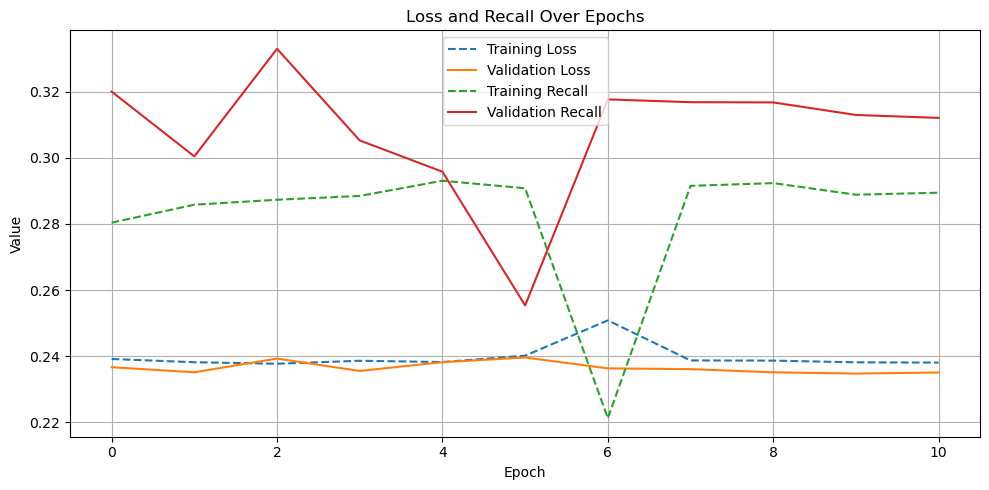

In [32]:
# Convert history to DataFrame
history_df = pd.DataFrame(history.history)

# Plot loss and recall curves
plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(history_df['loss'], label='Training Loss', linestyle='--')
plt.plot(history_df['val_loss'], label='Validation Loss')

# Plot recall
plt.plot(history_df['recall'], label='Training Recall', linestyle='--')
plt.plot(history_df['val_recall'], label='Validation Recall')

plt.title('Loss and Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on the test set
results = model.evaluate(X_test_preproc_df, y_test, verbose=0)
print("🧪 Test loss and metrics:", results)

KeyboardInterrupt: 

In [ ]:
# Get predicted probabilities
y_pred_proba = model.predict(X_test_preproc_df)
# Convert to binary labels using a threshold
y_pred = (y_pred_proba >= 0.5).astype(int)

264437/264437 [==============================] - 310s 1ms/step


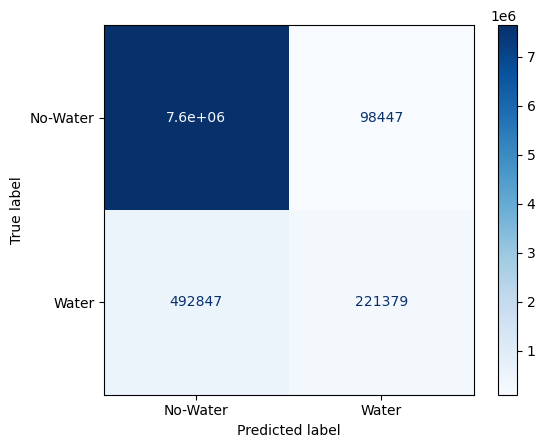

In [37]:
# Compute confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No-Water", "Water"])
disp.plot(cmap="Blues")

In [38]:
print(classification_report(y_test_np, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96   7747739
         1.0       0.69      0.31      0.43    714226

    accuracy                           0.93   8461965
   macro avg       0.82      0.65      0.70   8461965
weighted avg       0.92      0.93      0.92   8461965

